## Загрузка моделей

In [1]:

!wget -O /content/G_Anime.pth "https://github.com/AA-Sysyoev03/CLIP-Guided-Domain-Adaptation-of-Image-Generators/raw/main/models/G_Anime.pth"


!ls -lh /content/G_Anime.pth

--2026-02-07 19:44:10--  https://github.com/AA-Sysyoev03/CLIP-Guided-Domain-Adaptation-of-Image-Generators/raw/main/models/G_Anime.pth
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AA-Sysyoev03/CLIP-Guided-Domain-Adaptation-of-Image-Generators/main/models/G_Anime.pth [following]
--2026-02-07 19:44:10--  https://raw.githubusercontent.com/AA-Sysyoev03/CLIP-Guided-Domain-Adaptation-of-Image-Generators/main/models/G_Anime.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80900604 (77M) [application/octet-stream]
Saving to: ‘/content/G_Anime.pth’

/content/G_Anime.pt 100%[===================>]  7

In [2]:

!wget -O /content/G_Sketch.pth "https://github.com/AA-Sysyoev03/CLIP-Guided-Domain-Adaptation-of-Image-Generators/raw/main/models/G_Sketch.pth"


!ls -lh /content/G_Sketch.pth

--2026-02-07 19:47:40--  https://github.com/AA-Sysyoev03/CLIP-Guided-Domain-Adaptation-of-Image-Generators/raw/main/models/G_Sketch.pth
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AA-Sysyoev03/CLIP-Guided-Domain-Adaptation-of-Image-Generators/main/models/G_Sketch.pth [following]
--2026-02-07 19:47:40--  https://raw.githubusercontent.com/AA-Sysyoev03/CLIP-Guided-Domain-Adaptation-of-Image-Generators/main/models/G_Sketch.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80901199 (77M) [application/octet-stream]
Saving to: ‘/content/G_Sketch.pth’

/content/G_Sketch.p 100%[===================>

In [3]:
# Установка зависимостей
!pip -q install torch torchvision git+https://github.com/openai/CLIP.git
!pip -q install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

# Клонирование репозитория StyleGAN2
%cd /content
!git clone -q https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch


import sys, os, torch, numpy as np, matplotlib.pyplot as plt
import dnnlib, legacy
sys.path.append('/content/stylegan2-ada-pytorch')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.7 MB/s eta 0:00:00
/content
/content/stylegan2-ada-pytorch
 GPU: Tesla T4


In [4]:
import torch.nn.functional as F
import copy

# Классы CIFAR-10
CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Загрузка оригинальной модели
print("Загрузка оригинальной модели CIFAR-10...")
url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl'
with dnnlib.util.open_url(url) as f:
    G_original = legacy.load_network_pkl(f)['G_ema'].to(device).eval()
print(" Готово!\n")

# Поиск обученных моделей стилей
def find_style_models():
    styles = {"original": G_original}
    base = "/content"
    for fname in os.listdir(base):
        if fname.startswith("G_") and fname.endswith(".pth"):
            style_name = fname[2:-4]
            try:
                G = copy.deepcopy(G_original)
                G.load_state_dict(torch.load(f"{base}/{fname}", map_location=device))
                G = G.to(device).eval()
                styles[style_name] = G
                print(f"✓ Найдена модель стиля: {style_name}")
            except Exception as e:
                print(f"Ошибка загрузки {fname}: {e}")
    return styles

STYLES = find_style_models()
print(f"\nДоступные стили: {', '.join(STYLES.keys())}")

Загрузка оригинальной модели CIFAR-10...
 Готово!

✓ Найдена модель стиля: Sketch
✓ Найдена модель стиля: Anime

Доступные стили: original, Sketch, Anime


In [5]:
def generate_images(G, class_name, num_images=8, seed=42):
    """Генерация изображений из модели"""
    torch.manual_seed(seed)
    z = torch.randn(num_images, G.z_dim, device=device)
    class_idx = CLASSES.index(class_name)
    c = F.one_hot(
        torch.full((num_images,), class_idx, dtype=torch.long, device=device),
        num_classes=10
    ).float()

    with torch.no_grad():
        w = G.mapping(z, c)
        imgs = G.synthesis(w, noise_mode='random')
    return imgs

def show_images(images, title=""):
    """Показать изображения без осей и подписей"""
    n = images.shape[0]
    fig, axes = plt.subplots(1, n, figsize=(n * 1.3, 1.5))

    for i in range(n):
        ax = axes[i] if n > 1 else axes
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = np.clip(img * 0.5 + 0.5, 0, 1)
        ax.imshow(img, interpolation='nearest')
        ax.axis('off')

    if title:
        plt.suptitle(title, fontsize=14, y=0.92)
    plt.tight_layout()
    plt.show()

Генерация: Sketch automobile (8 изображений)...
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 111, in get_plugin
    module = importlib.import_module(module_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/importlib/__init__.py", line 90, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<fro

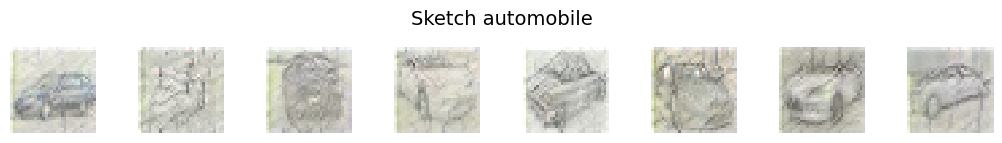

In [11]:

STYLE = "Sketch"      # "original", "Anime", "Sketch".
CLASS = "automobile"
NUM_IMAGES = 8
SEED = 42
# ===========================================

# Проверка корректности
if STYLE not in STYLES:
    print(f"Стиль '{STYLE}' не найден. Используется 'original'.")
    STYLE = "original"

if CLASS not in CLASSES:
    print(f"Класс '{CLASS}' не существует. Используется 'bird'.")
    CLASS = "bird"

# Генерация
print(f"Генерация: {STYLE} {CLASS} ({NUM_IMAGES} изображений)...")
images = generate_images(STYLES[STYLE], CLASS, NUM_IMAGES, SEED)

# Показ
show_images(images, title=f"{STYLE} {CLASS}")

# Сохранение
fname = f"/content/{STYLE}_{CLASS}.png"
plt.figure(figsize=(NUM_IMAGES * 1.3, 1.5))
for i in range(NUM_IMAGES):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = np.clip(img * 0.5 + 0.5, 0, 1)
    plt.subplot(1, NUM_IMAGES, i+1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
plt.tight_layout()
plt.savefig(fname, dpi=150, bbox_inches='tight', pad_inches=0)
plt.close()
